# IMPORT LIBRARIES

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [144]:
import python_libraries.data_loading as loadfunc
import python_libraries.data_processing as procfunc
import python_libraries.sigmoid_fitting as fitfunc
import python_libraries.grouping_function as groupfunc
import python_libraries.score_processing as scorefunc
import python_libraries.plotting_function as plotfunc
import python_libraries.utilities as utils

In [145]:
NMETA = 6

# LOAD DATA

In [52]:
data_path = '/Users/yuwenchen/OneDrive - Imperial College London/Sigmoidal_curves_explore_YC/data'
data_selected_path = f'{data_path}/20210719_7_plex'

In [53]:
df_dilution = pd.read_csv(f'{data_selected_path}/raw_data/20210719_01.csv', index_col=0)

In [54]:
combo_dict = {0: 'bottom_six',
              1: 'middle_six',
              2: 'top_six',
              3: 'top_mean',
              4: 'top_min'}

combo_group_id = [0, 1, 2, 3, 4]

In [55]:
df_combination = loadfunc.load_selected_combo(data_selected_path, combo_group_id, combo_dict)
df_combination = df_combination[~df_combination.index.isin(['PM7.2299'])]

# DATA PREPROCESSING

## Data downselection

In [56]:
df_dilution = utils.data_downselection(df_dilution, 'Sample', ['Water'], keep=False)

## Data filtering

In [57]:
df_dilution_filtered = procfunc.raw_data_filtering(df_dilution, NMETA)

# DATA PLOTTING

In [58]:
colormap = [f'C0{i}' for i in range(len(df_dilution_filtered['Conc.'].unique()))]

In [59]:
df_dilution_filtered = utils.order_columns(df_dilution_filtered, NMETA)

<ipython-input-61-45fd85467925>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 7, figsize=(30, 3), dpi=100)


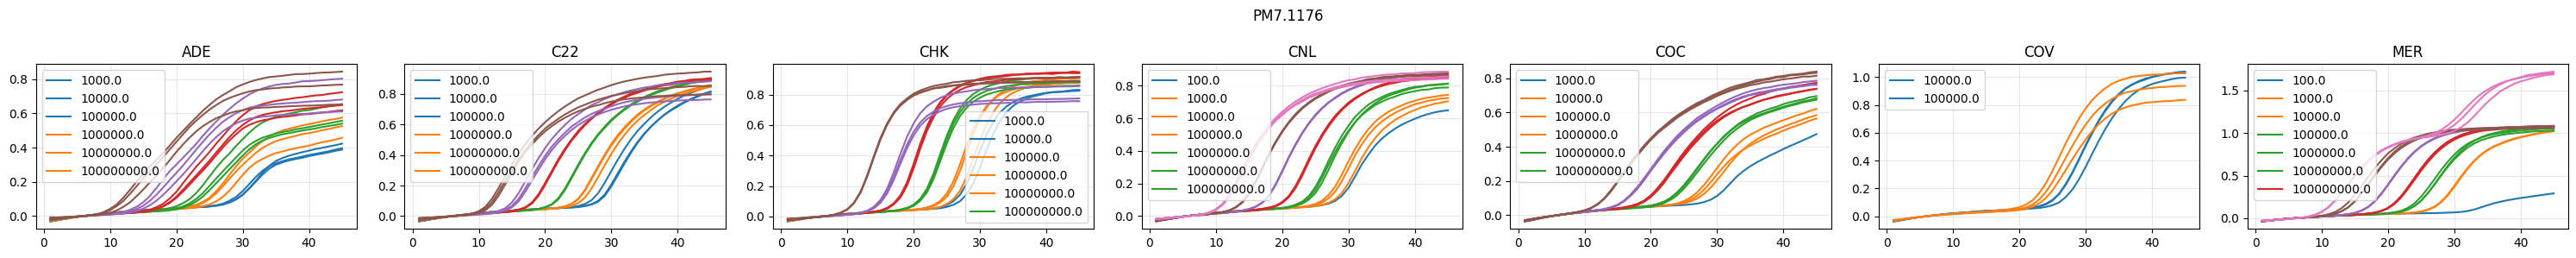

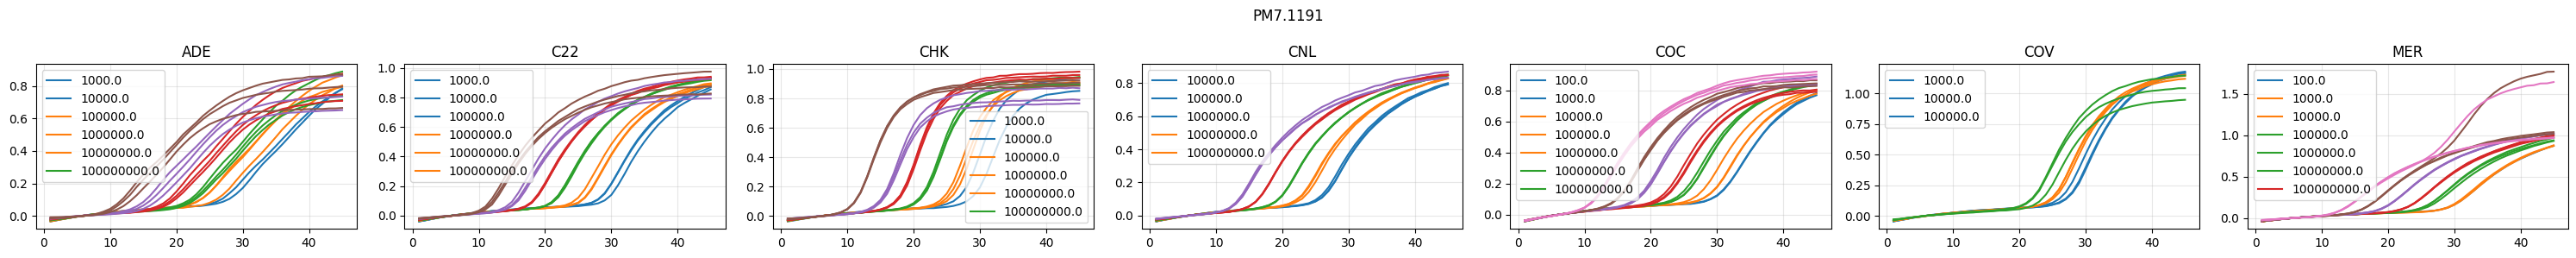

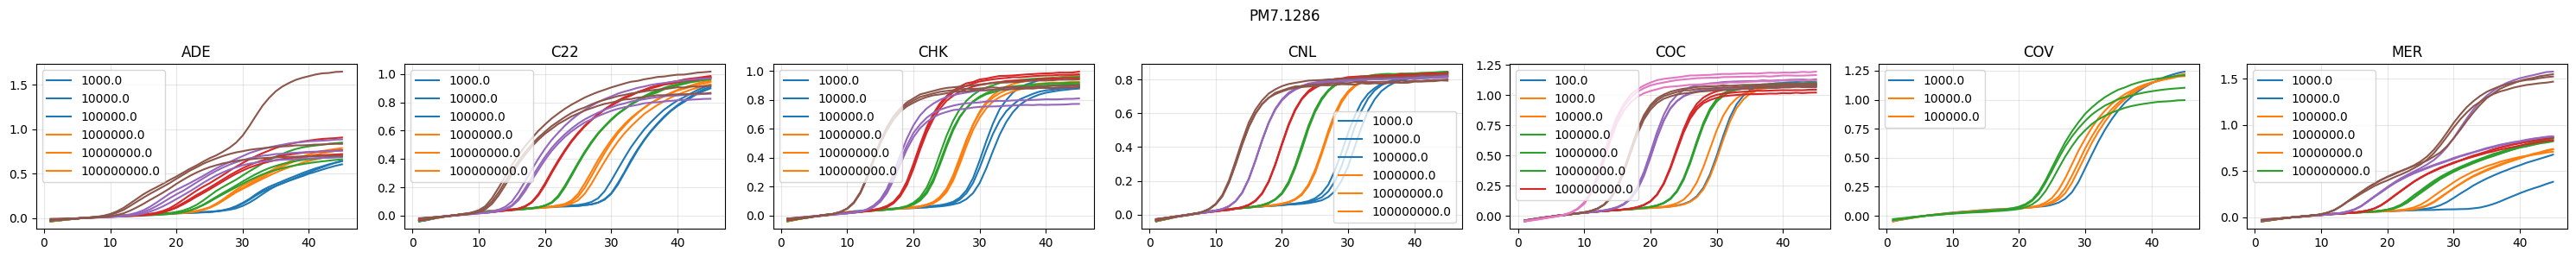

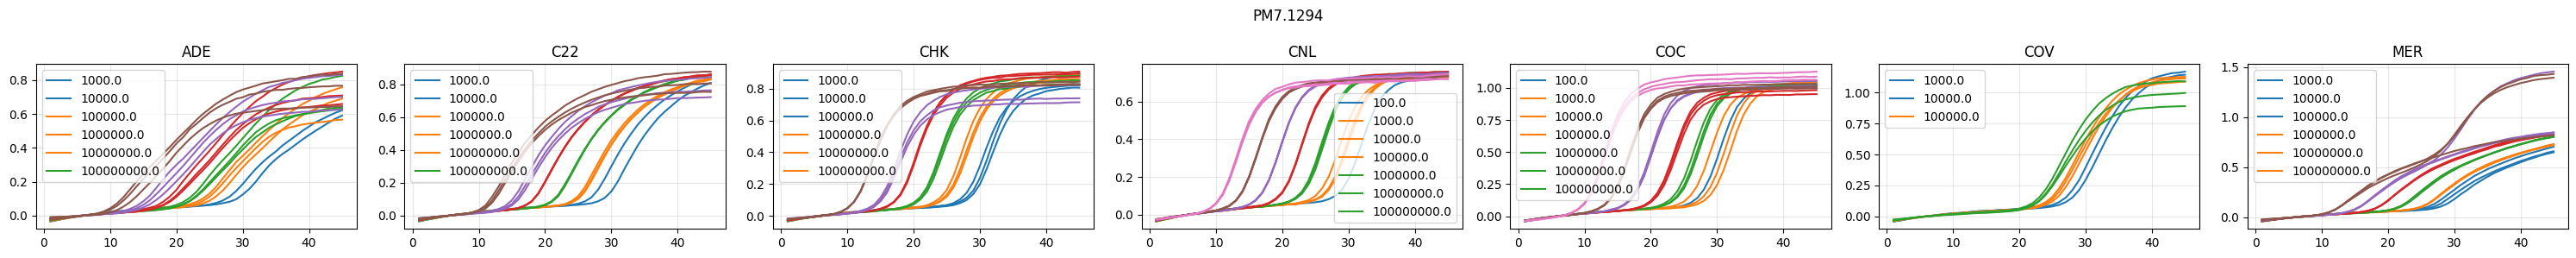

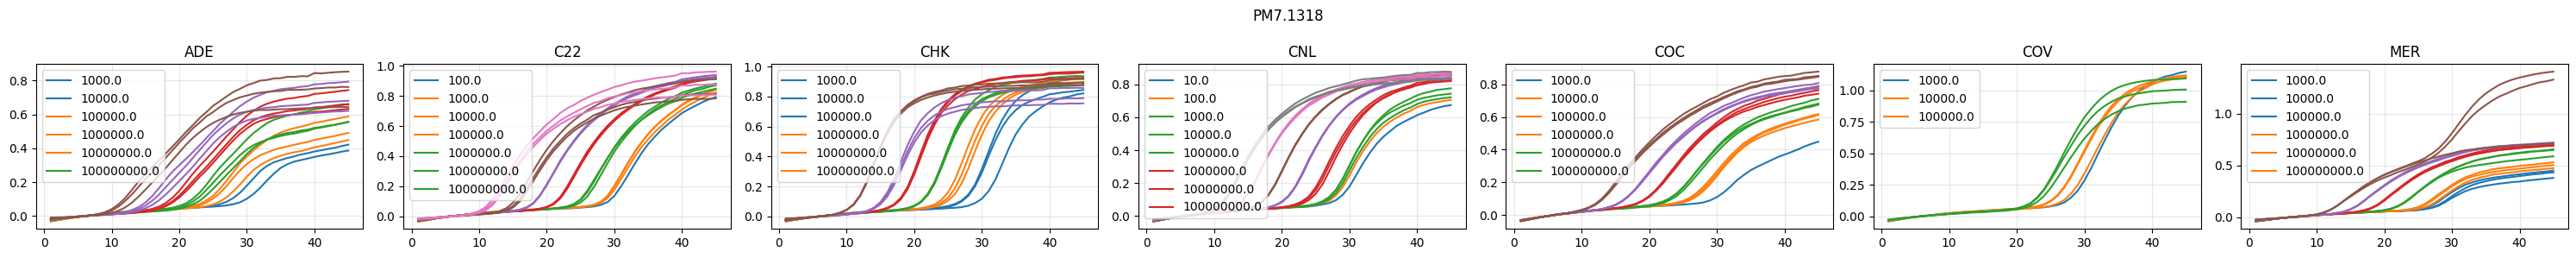

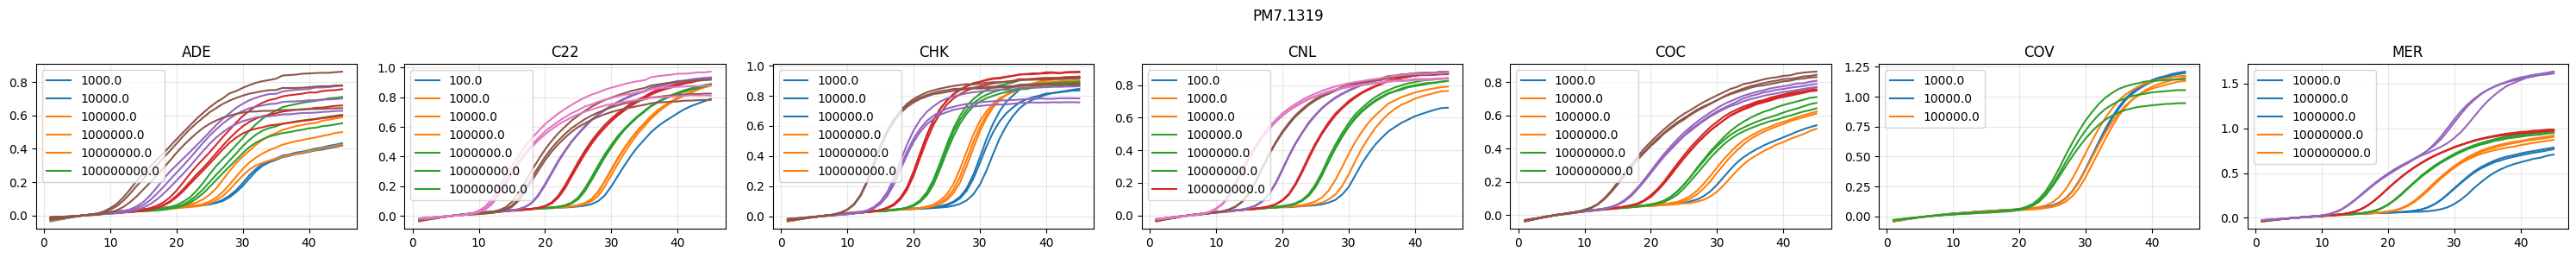

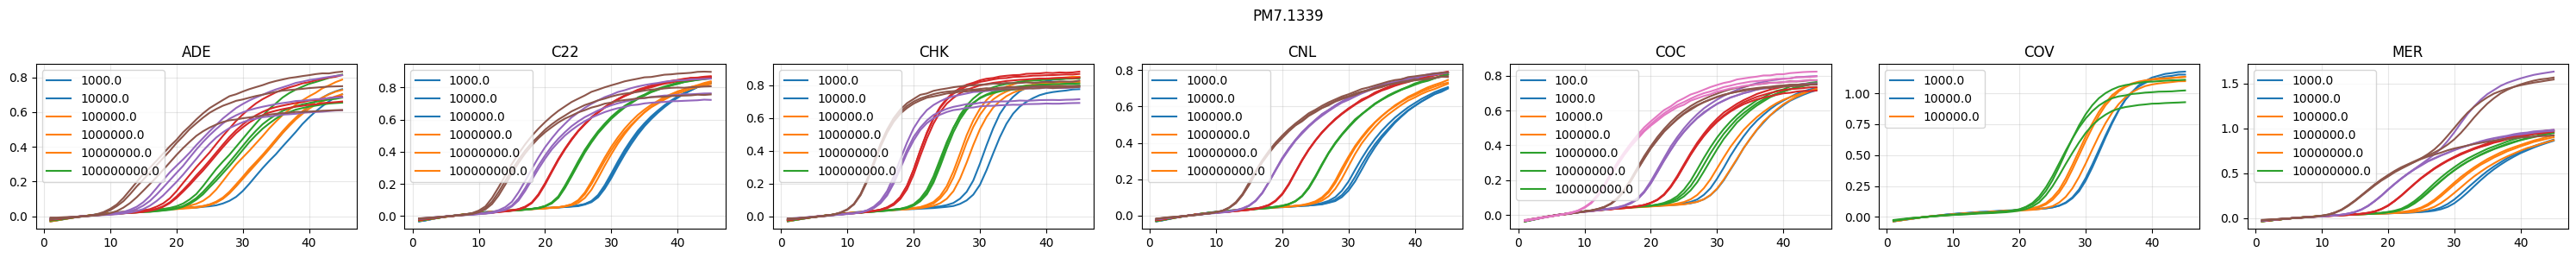

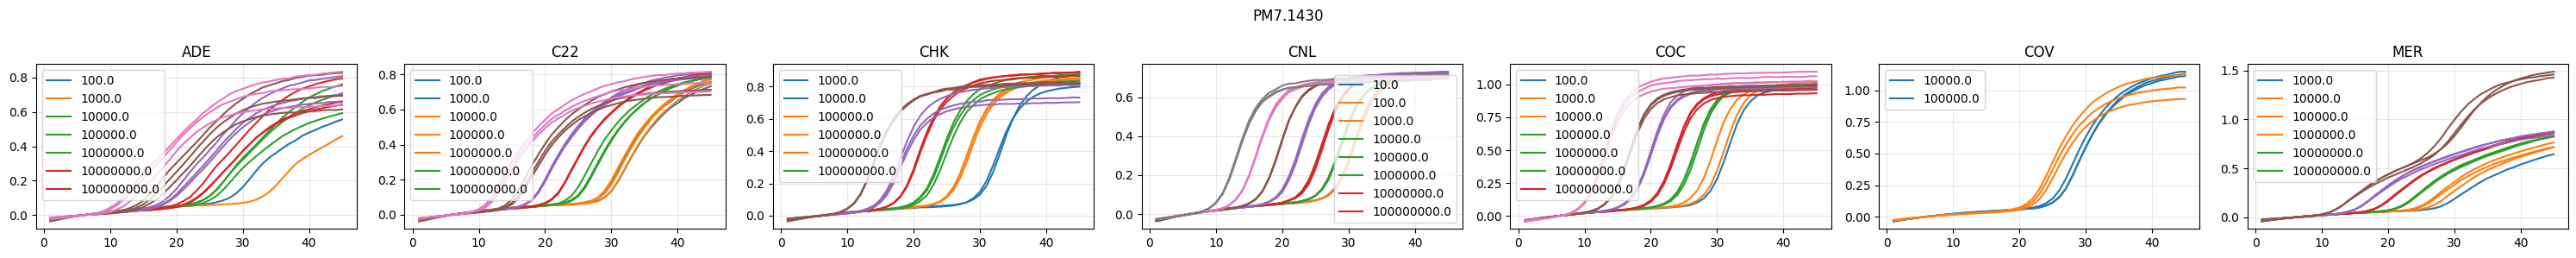

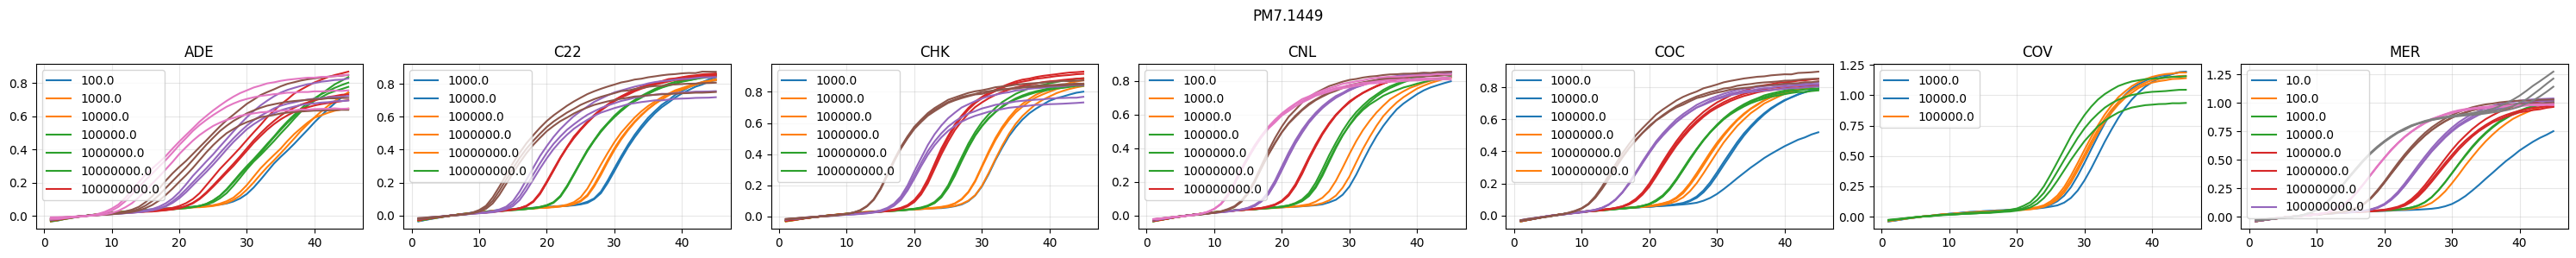

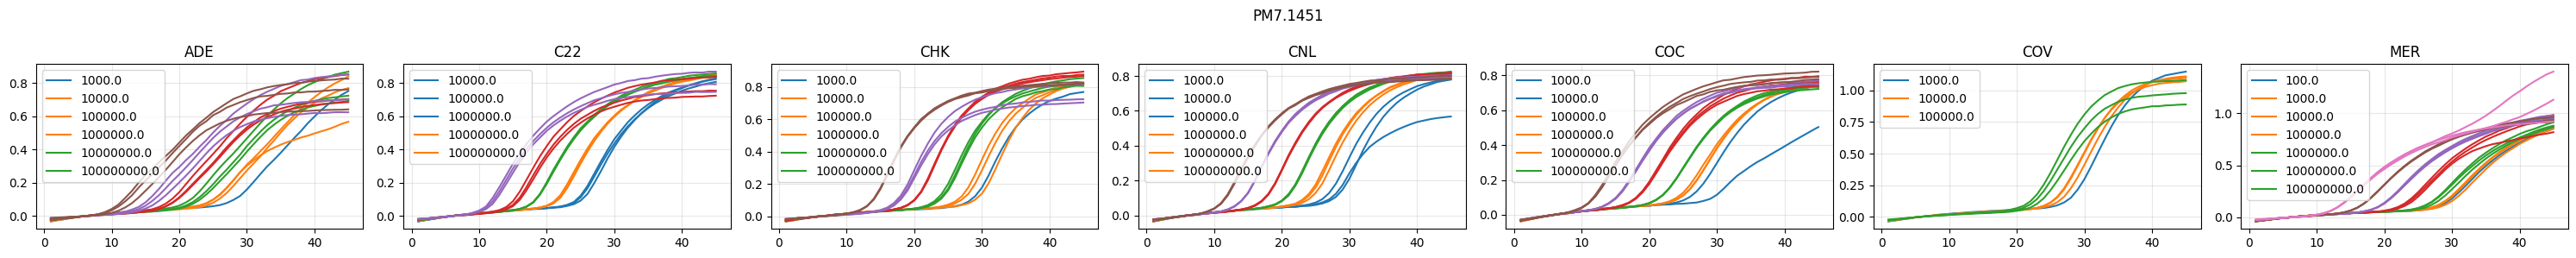

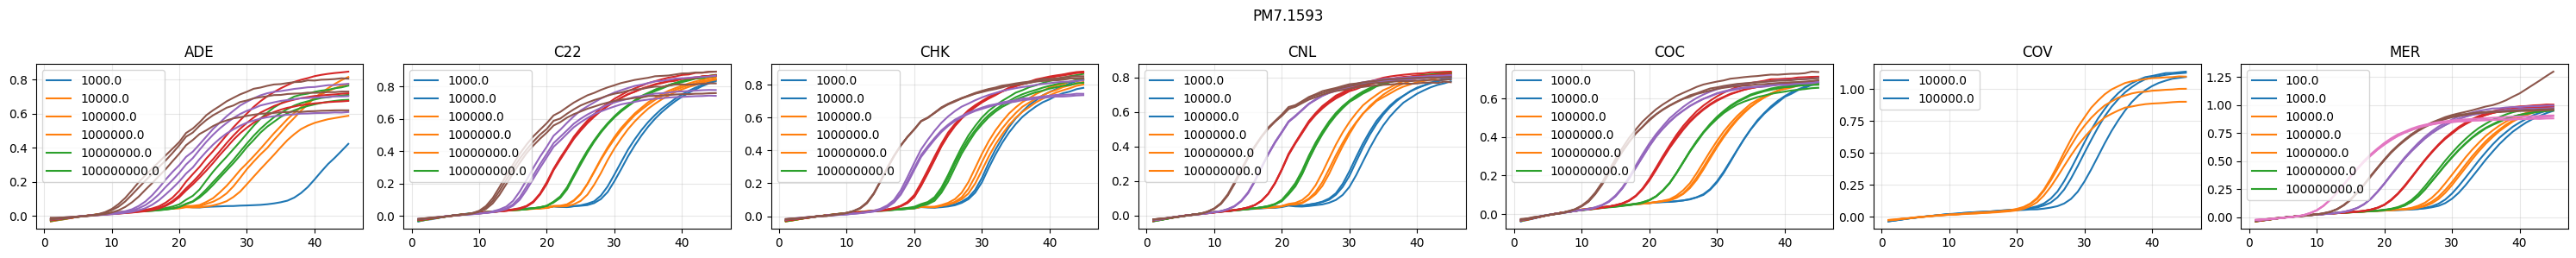

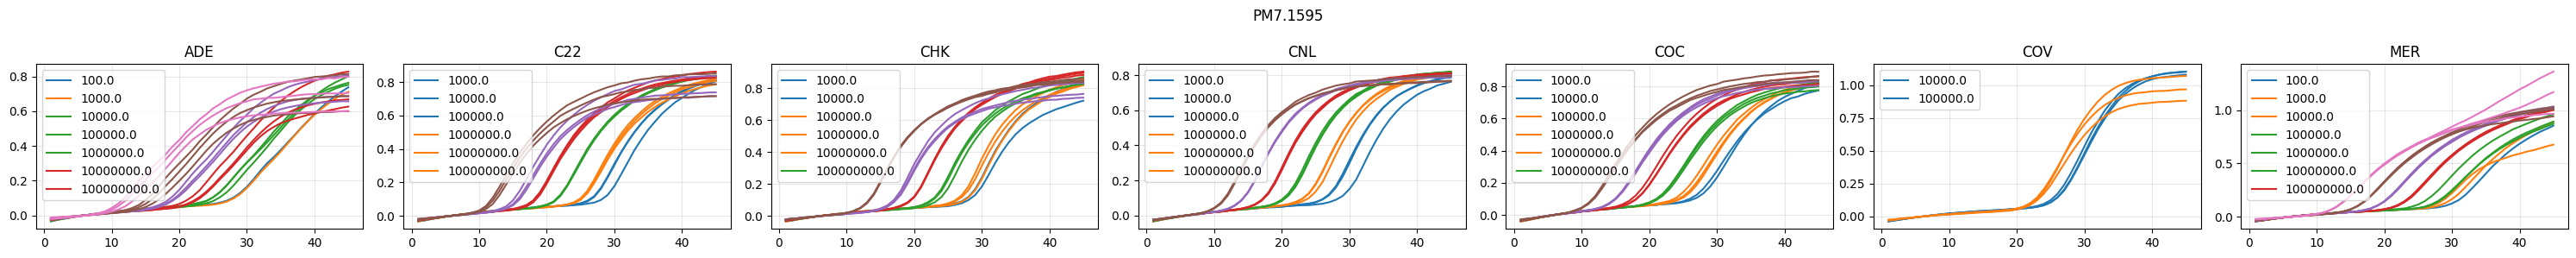

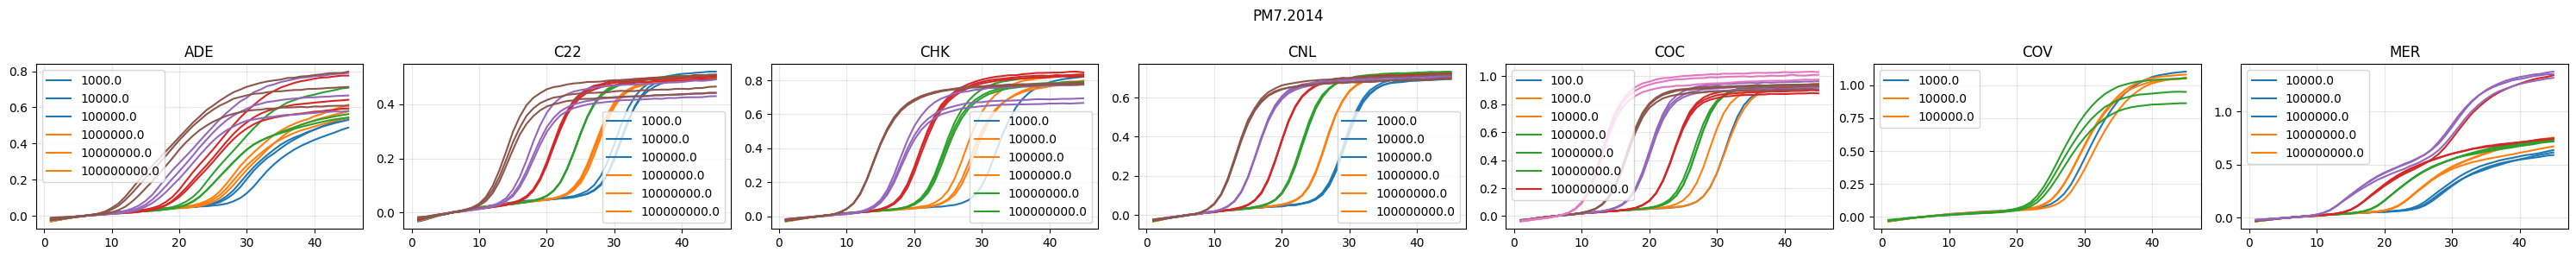

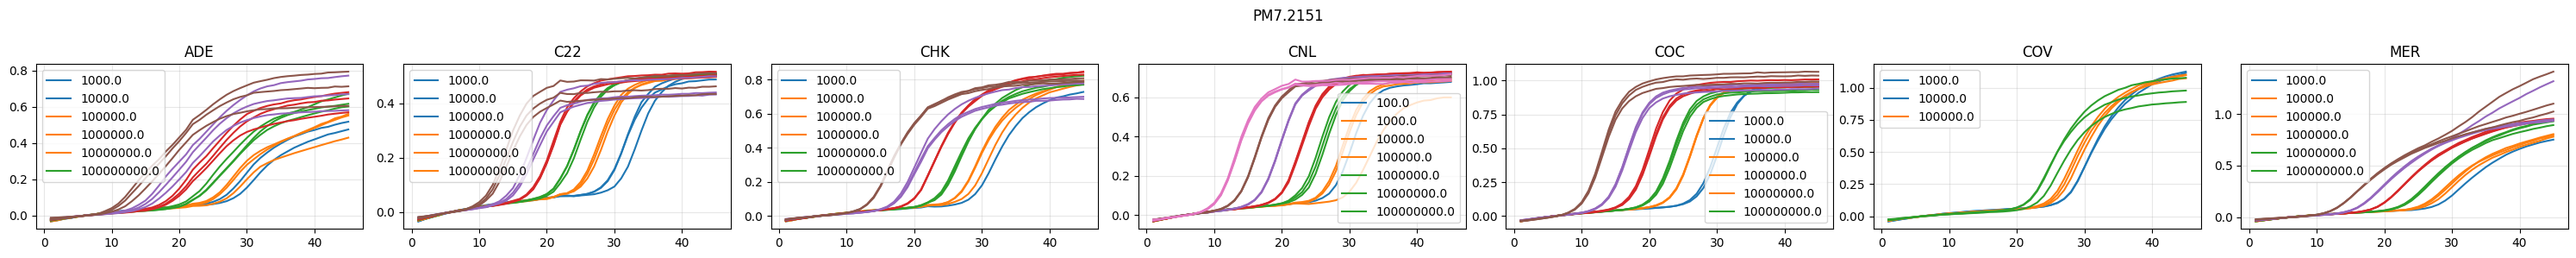

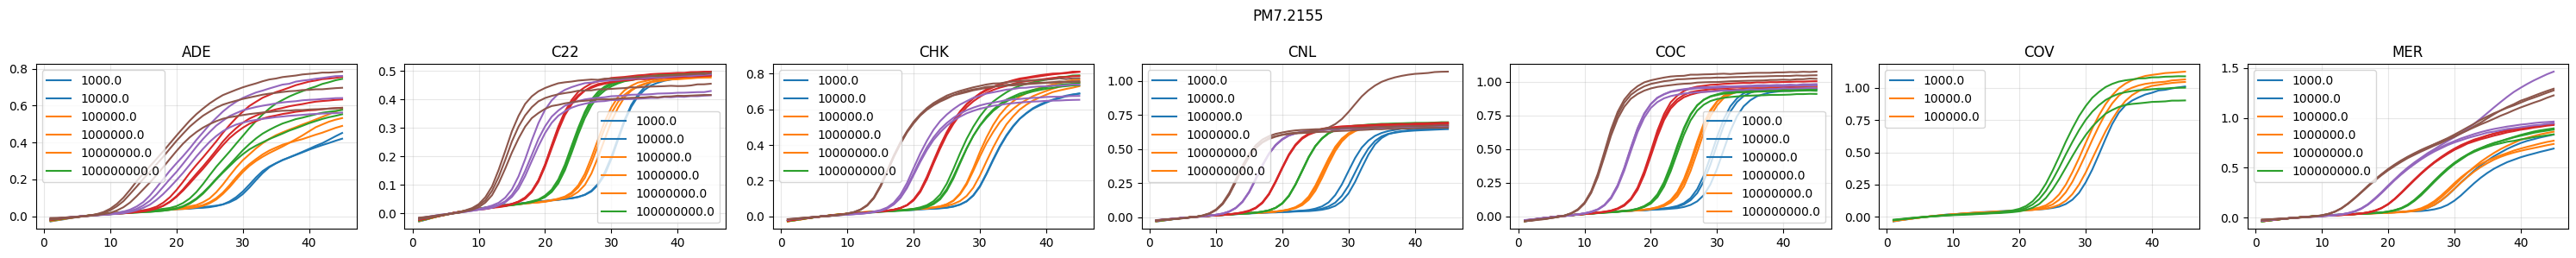

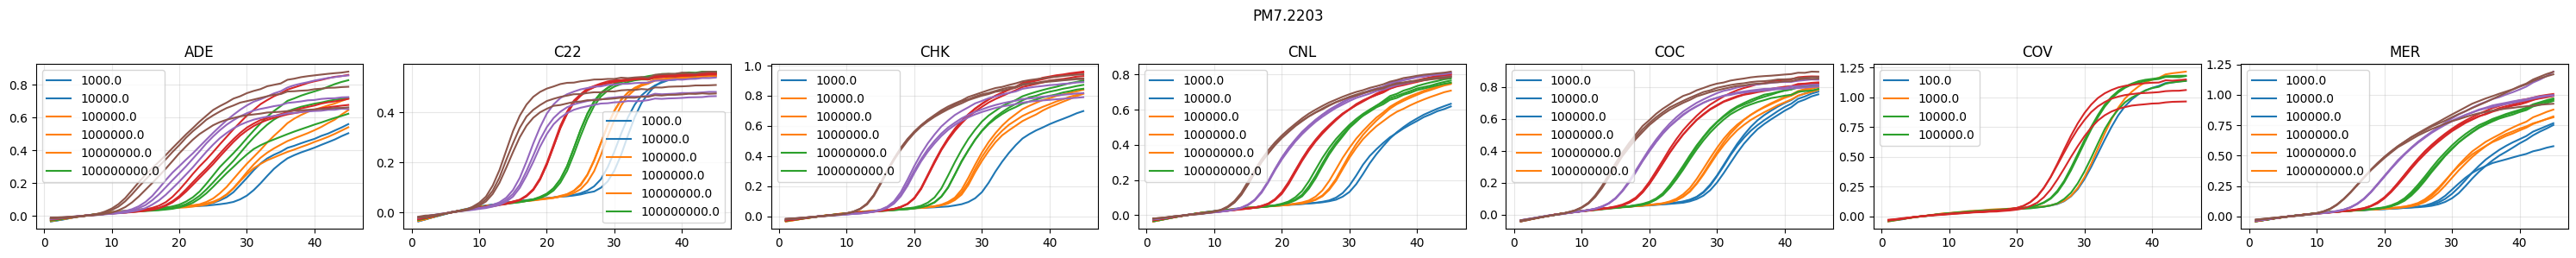

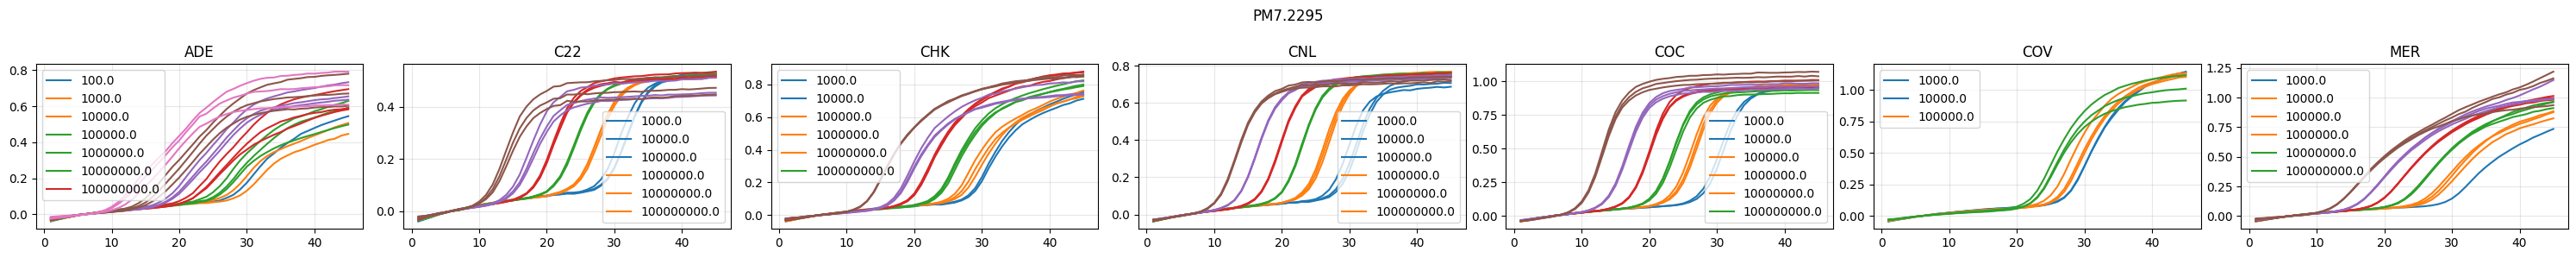

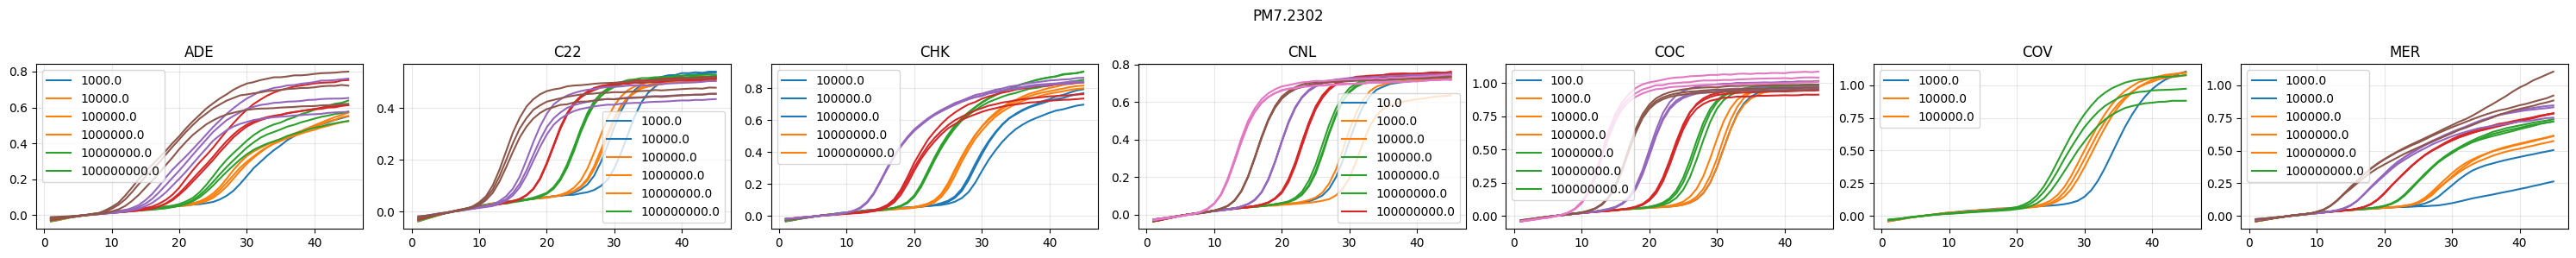

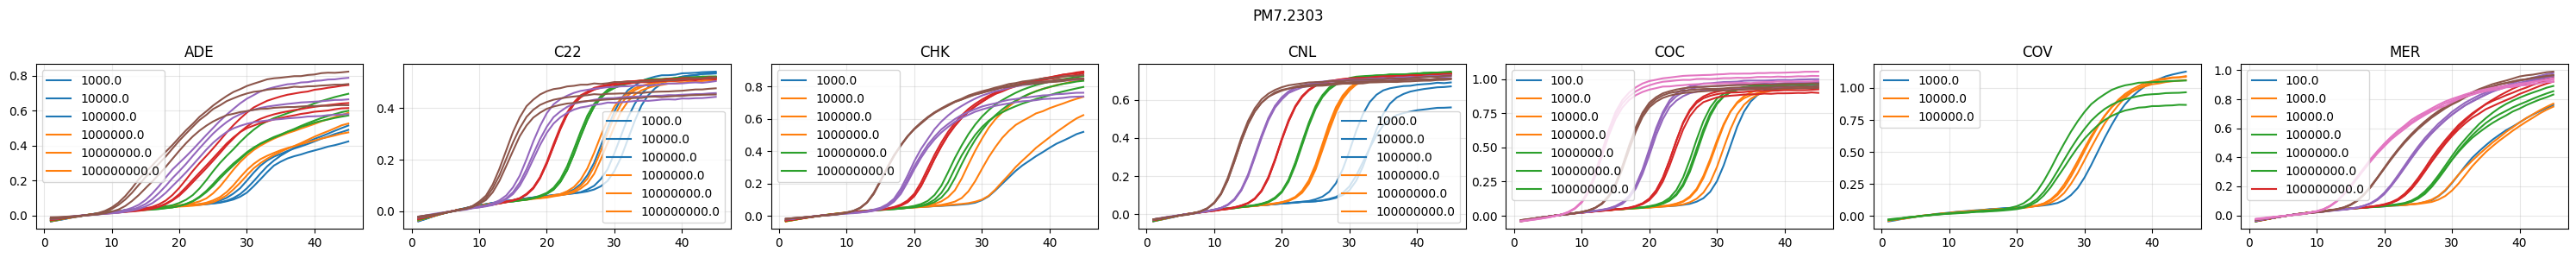

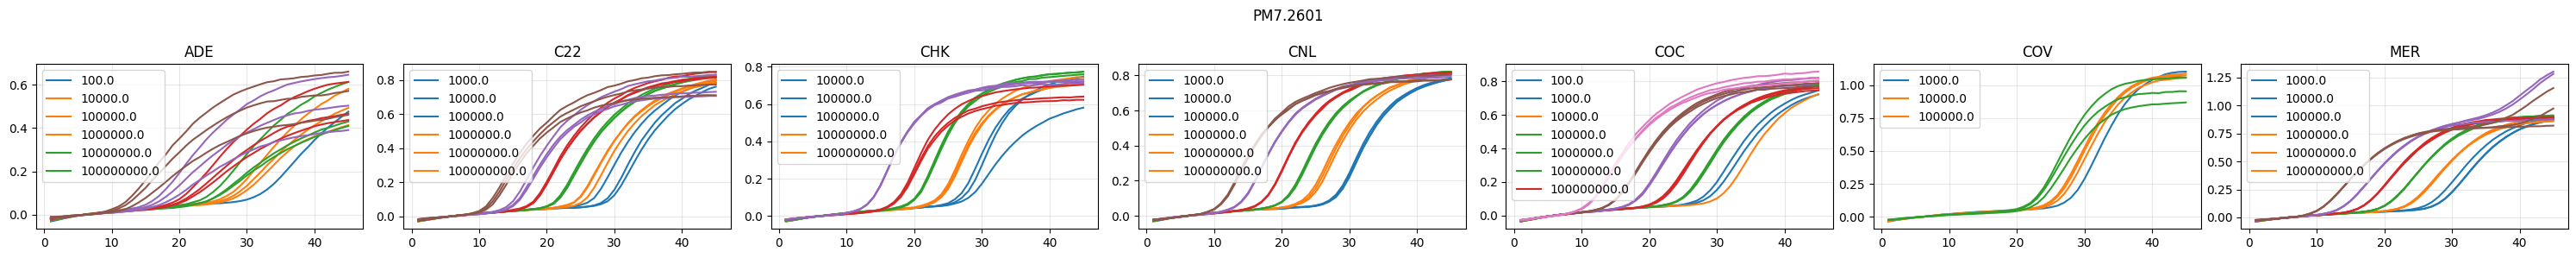

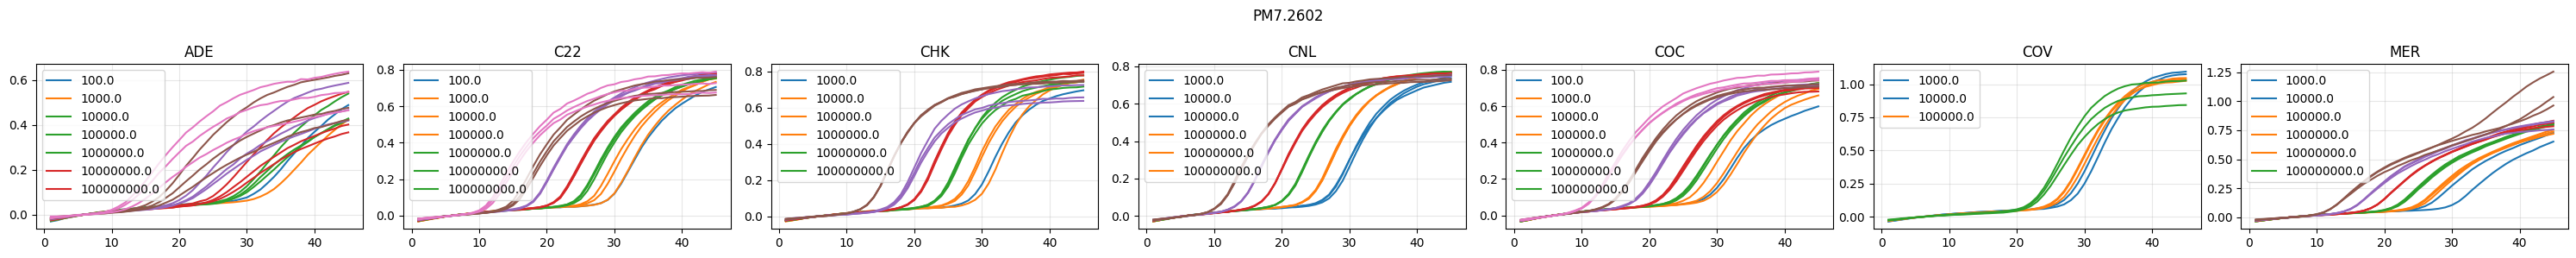

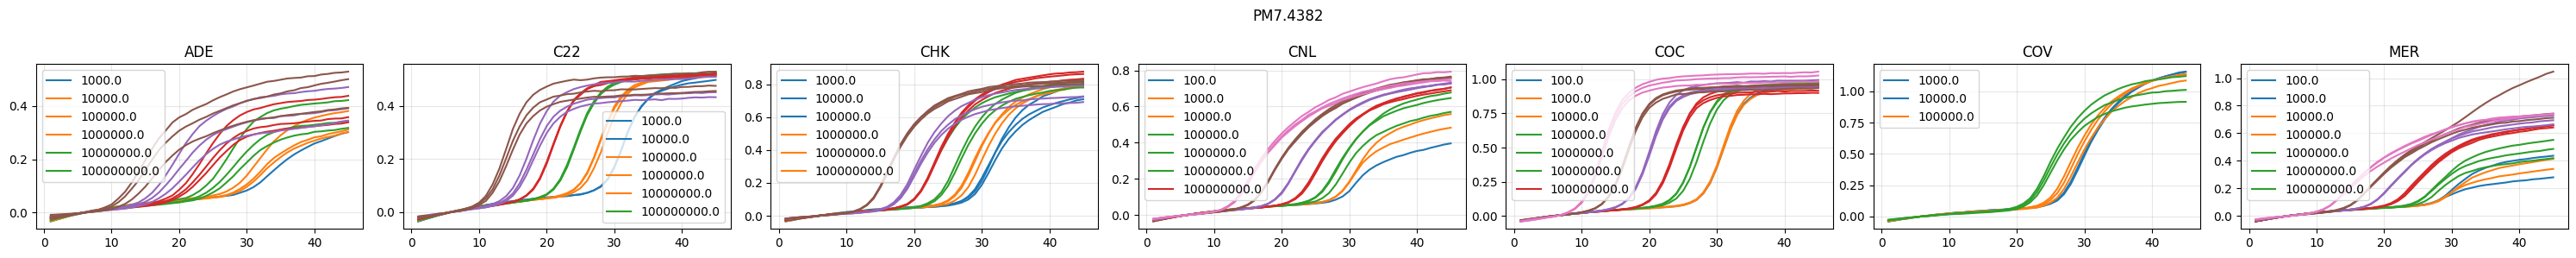

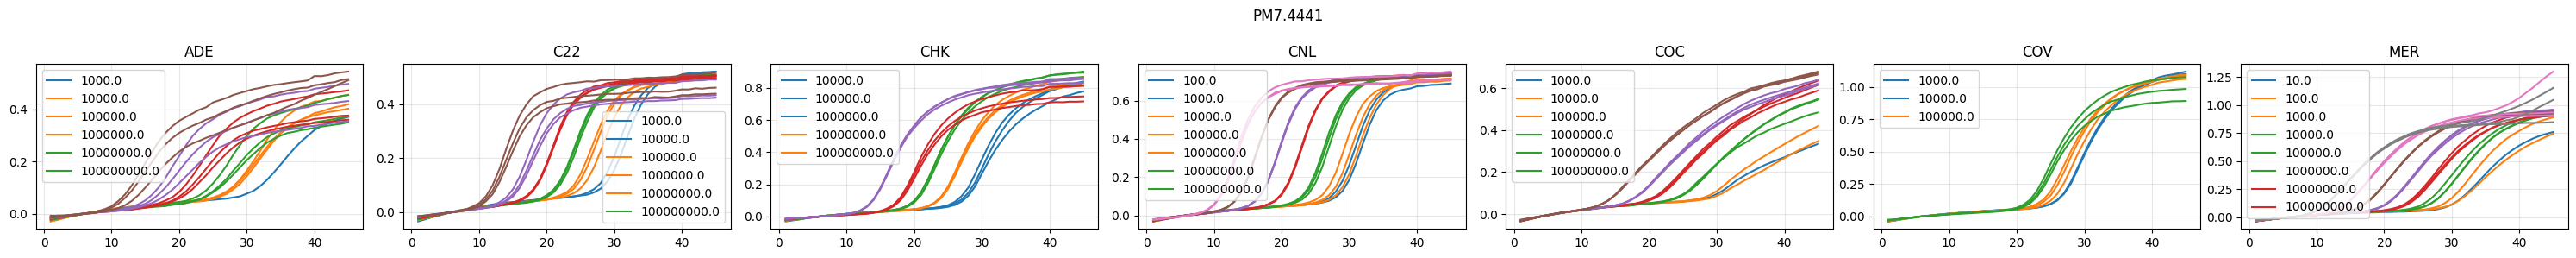

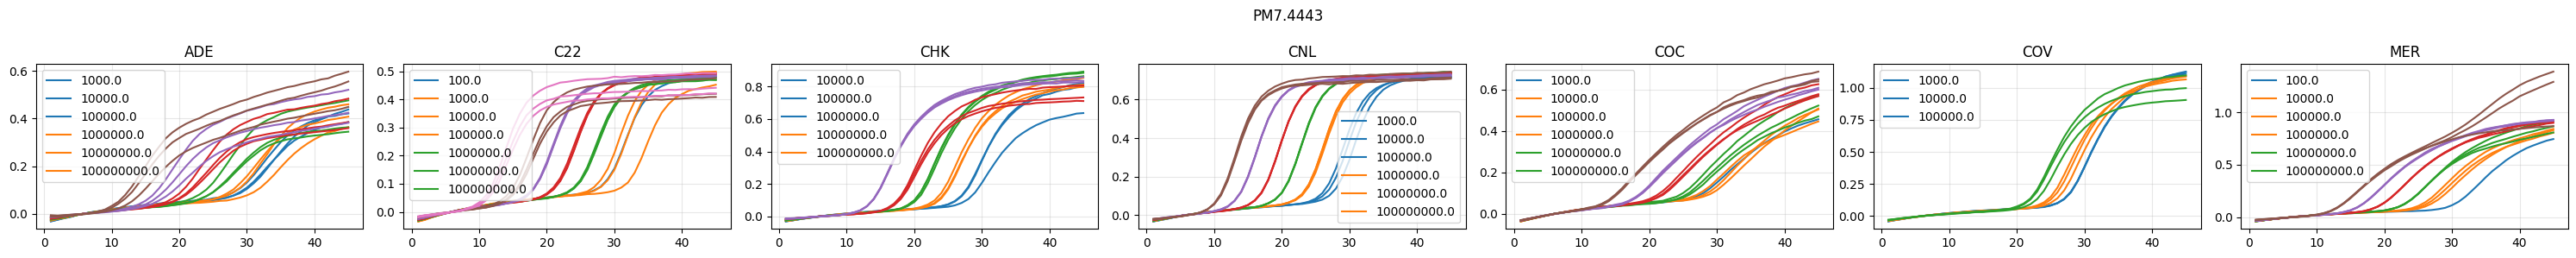

In [61]:
for primer, df in df_dilution_filtered.groupby('Gene'):
    
    fig, ax = plt.subplots(1, 7, figsize=(30, 3), dpi=100)
    
    fig.suptitle(f'{primer}')
    
    for index, (assay, df_) in enumerate(df.groupby('Sample')):
        
        label_list = []
        
        for (conc, df_temp), color in zip(df_.groupby('Conc.'), colormap):
            
            ax[index].plot(df_temp.iloc[:, NMETA:].T, color=color)
            
            label_list.append(conc)
        
        ax[index].set_title(assay)
        ax[index].legend(label_list)
        ax[index].grid(alpha=0.3)
        
    plt.tight_layout()
    fig.savefig(f'{data_path}/dilution_figure/{primer}.pdf')

# Conc 1e5

In [105]:
df_score_multiplex = pd.read_csv('/Users/yuwenchen/OneDrive - Imperial College London/Sigmoidal_curves_explore_YC/data/20210716_7_plex/score_data/score_c_param_multiplex_selected.csv', index_col=0)

In [106]:
df_dilution_1e5 = utils.data_downselection(df_dilution_filtered, 'Conc.', [100000.0], keep=True)

In [119]:
df_dilution_1e5 = df_dilution_1e5.rename(columns={'Gene': 'PrimerMix', 'Sample': 'Target'})

df_list = []

for primer, df in df_dilution_1e5.groupby('PrimerMix'):
    for target, df_ in df.groupby('Target'):
        if target == 'ADE':
            df_['Assay'] = np.repeat(df_score_multiplex[df_score_multiplex['PrimerMix'] == primer]['Assay1'].values, df_.shape[0])
        if target == 'C22':
            df_['Assay'] = np.repeat(df_score_multiplex[df_score_multiplex['PrimerMix'] == primer]['Assay2'].values, df_.shape[0])
        if target == 'CHK':
            df_['Assay'] = np.repeat(df_score_multiplex[df_score_multiplex['PrimerMix'] == primer]['Assay3'].values, df_.shape[0])
        if target == 'CNL':
            df_['Assay'] = np.repeat(df_score_multiplex[df_score_multiplex['PrimerMix'] == primer]['Assay4'].values, df_.shape[0])
        if target == 'COC':
            df_['Assay'] = np.repeat(df_score_multiplex[df_score_multiplex['PrimerMix'] == primer]['Assay5'].values, df_.shape[0])
        if target == 'COV':
            df_['Assay'] = np.repeat(df_score_multiplex[df_score_multiplex['PrimerMix'] == primer]['Assay6'].values, df_.shape[0])
        if target == 'MER':
            df_['Assay'] = np.repeat(df_score_multiplex[df_score_multiplex['PrimerMix'] == primer]['Assay7'].values, df_.shape[0])
        
        df_list.append(df_)

df_dilution_assay = pd.concat(df_list, axis=0).reset_index(drop=True)

In [122]:
NMETA = 7

# SIGMOID FITTING

In [131]:
bounds = (-100, 100)
maxfev = 1000000
core_number = 16
thresh_MSE = 0.0001
func = fitfunc.Five_Parameter_Sigmoid

## Pivot fitting

In [132]:
p0_initial = fitfunc.pivot_fitting(df_dilution_assay, func,
                                   NMETA, bounds, maxfev, core_number, thresh_MSE, seed=0)

print('Initial p0: ', p0_initial)

Initial p0:  [ 4.88072663e-01 -7.48855207e-04  2.99665047e-01  3.07205462e+01
  8.41874527e-01]


## Fit all data

In [133]:
df_fitted_param, df_fitted_curve = fitfunc.sigmoid_fitting_parallel(df_dilution_assay, 
                                                                    NMETA, func, p0_initial, 
                                                                    bounds, maxfev, core_number)

In [134]:
df_fitted_param.to_csv(f'{data_selected_path}/processed_data/fitted_param_multiplex.csv')
df_fitted_curve.to_csv(f'{data_selected_path}/processed_data/fitted_curve_multiplex.csv')

# COMPUTING SCORE

In [135]:
curve_type_dict = {0: 'c_param'}

In [136]:
DATA_TYPE = 'multiplex'

In [139]:
for key in curve_type_dict:
    
    CURVE_TYPE = curve_type_dict[key]
    print(f'Computing {DATA_TYPE.upper()} scores for: {curve_type_dict[key].upper()}')
    
    df_to_compute = loadfunc.load_processed_data_by_name(data_selected_path, CURVE_TYPE, DATA_TYPE, NMETA)
    
    pm_data = groupfunc.get_primermix_dataframes(df_to_compute, df_combination, DATA_TYPE)
    
    df_score = scorefunc.compute_score(df_to_compute, NMETA, pm_data)
    df_score.to_csv(f'{data_selected_path}/score_data/score_{CURVE_TYPE}_{DATA_TYPE}_selected.csv')

Computing MULTIPLEX scores for: C_PARAM


# CORRELATION PLOTTING

In [140]:
df_score_dilution = pd.read_csv(f'{data_selected_path}/score_data/score_c_param_multiplex_selected.csv', index_col=0)

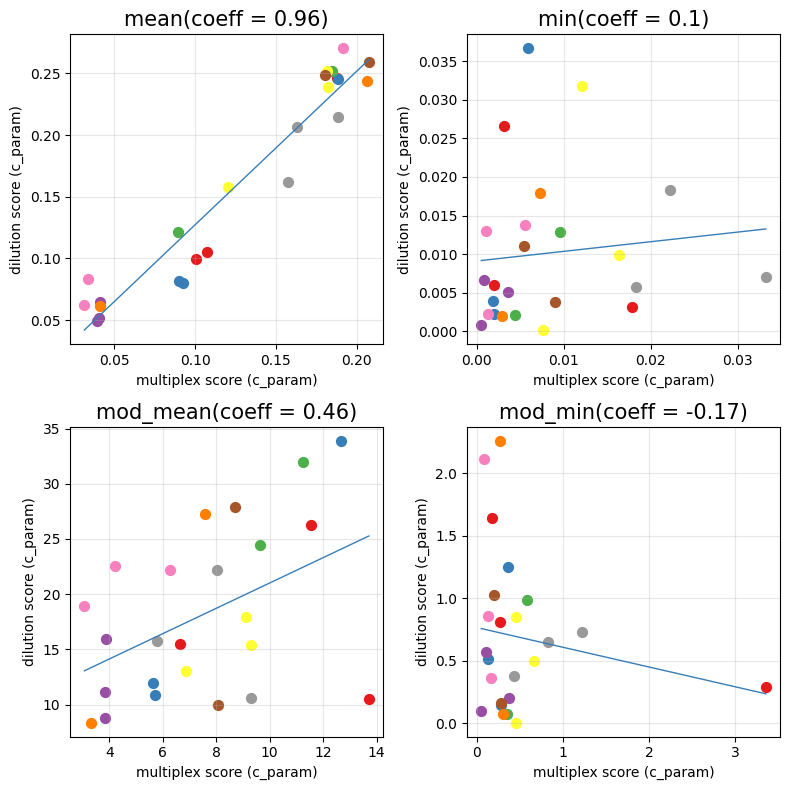

0         1         2         3
Metric                       mean       min  mod_mean   mod_min
Correlation coefficient  0.964855  0.103294  0.456509 -0.170181

In [146]:
NMETA = 50

fig = plotfunc.scatter_plot_with_correlation_line(df_score_multiplex.iloc[:, NMETA:], df_score_dilution.iloc[:, NMETA:],
                                            'multiple_single', col_number = 2, size = (8, 8), multi_color = True, x_label = 'multiplex score (' + CURVE_TYPE + ')', y_label = 'dilution score (' + CURVE_TYPE + ')',
                                            primer = df_score_multiplex['PrimerMix'].values, dot_size = 50)

scorefunc.generate_correlation_df_S2M(df_score_multiplex.iloc[:, NMETA:], df_score_dilution.iloc[:, NMETA:])